# Predicting Used Cars Sale Price
Buying and selling a car are important decision as prices are usually high, even for used cars. For this reason, it's important for sellers to be able to estimate their car at a right price and avoid underestimation, as for buyers to avoid choosing a car that is selling above their expected value.

### Objective
The purpose of this project is to predict sale price of used cars based on different characteristics of a given car.

### Performance
To do so, a regression model will be built and tuned in order to minimise the error of prediction. The performance will be measured by:
* **RMSE:** Root Squared of the Mean Squared Error. It is calculated by the sum of square of prediction error: $\sum(\hat{y}-y)^2/N$. Less robust to outliers, it gives a higher weight to large errors (as all errors are squared).
* **MAE:** Mean Absolute Error. It is the sum of the average absolute errors, this means that positive and negative errors cancel each other out. However, this also means that the effect of outliers is reduced with respect to RMSE. 
* **R2:** "*proportion of the variation in the dependent variable that is predictable from the independent variable.*" (source: Wikipedia)

===================================================================================================

# Feature Engineering & Feature Selection
===================================================================================================

# Import Libraries

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

# for splitting train/test sets
from sklearn.model_selection import train_test_split

# for handling outliers
from feature_engine.outliers import Winsorizer

# for scaling data
from sklearn.preprocessing import MinMaxScaler

# for encoding categorical variables
from feature_engine.encoding import OneHotEncoder, RareLabelEncoder, CountFrequencyEncoder

# for bringing external data
import pickle

# for text processing
import re

# to display all the columns of the dataframe in the notebook & all float numbers rounded to 2digits
pd.pandas.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

# Load & split data

In [2]:
# Loading the raw_dataset
raw_data = pd.read_csv('scraped_data_used_cars.csv')

In [3]:
# Removing duplicates
data = raw_data.drop_duplicates()

# Removing unnecesary feature
data = data.drop(['Model'], axis = 1) 

# Removing rows containing errors & extreme values
years_with_errors = data[(data.Years < 1800) | (data.Years > 2022)].index
data = data.drop(years_with_errors)

extreme_prices = data[(data['Prices'] < 500) | (data['Prices'] > 600000)].index
data = data.drop(extreme_prices)

seats_with_errors = data[data.Seats > 10]['Seats'].values
data.Seats = data.Seats.replace(to_replace = seats_with_errors, value = np.nan)

# Removing rows with missing prices
data = data.dropna(subset = ['Prices'])

# Checking result
print('Data without errors:', data.shape)
data.head(3)

Data without errors: (48575, 11)


,Prices,Years,Brand,Kms,Fuel,Emiss_CO2,Cons_litres_100km,Transmission,Doors,Power_CV,Seats
0,21250.00,2019.00,Renault,9500.00,Essence,136.00,6.00,Manuelle,4.00,9.00,5.00
2,22000.00,1974.00,Volkswagen,100000.00,Essence,165.00,6.80,Manuelle,2.00,9.00,4.00
4,1500.00,2006.00,Toyota,278000.00,Diesel,82.00,6.20,Manuelle,4.00,7.00,5.00


In [4]:
train_set, test_set = train_test_split(data, test_size = 0.1, random_state = 42) 

# Checking result
print('Train set without errors:', train_set.shape)

Train set without errors: (43717, 11)


In [5]:
# Separing target from features
X_train = train_set.drop(['Prices'], axis=1) # predictive variables
y_train = train_set[['Prices']] # target

X_train.shape, y_train.shape

((43717, 10), (43717, 1))

===================================================================================================
# Feature Engineering
===================================================================================================

# Target

In [6]:
y_train = np.log(y_train)

# Missing Values

## Categorical variables
* If variable contains **more than 10%** of missing data => replace missing values by **"missing"**
* If variables contains **less than 10%** of missing data => replace with **most frequent category**

In [7]:
# Identify categorical variables 
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']

# Identify those with missing values
cat_vars_nan = [var for var in cat_vars if X_train[var].isnull().sum() > 0]

# print percentage of missing values per variable
X_train[cat_vars_nan].isnull().mean().sort_values(ascending=False)

Transmission   0.08
Fuel           0.05
Brand          0.00
dtype: float64

In [8]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_nan if X_train[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in cat_vars_nan if X_train[var].isnull().mean() < 0.1]

In [9]:
# replace missing values with new label: "Missing"
X_train[with_string_missing] = X_train[with_string_missing].fillna('Missing')

In [10]:
for var in with_frequent_category:
    # there can be more than 1 mode in a variable we take the first one with [0]    
    mode = X_train[var].mode()[0]
    
    print('Most frequent', var, ':' ,mode)
    
    X_train[var].fillna(mode, inplace=True)

Most frequent Brand : Renault
Most frequent Fuel : Diesel
Most frequent Transmission : Manuelle


In [11]:
# check that there are no remaining missing values
X_train[cat_vars_nan].isnull().sum()

Brand           0
Fuel            0
Transmission    0
dtype: int64

## Numerical variables
* First, add binary missing indicator variables
* Then, replace missing values with variable mean value

In [12]:
# Identify the numerical variables
num_vars = [var for var in X_train.columns if var not in cat_vars]

# Identify continuous variables
cont_vars = [var for var in num_vars if len(X_train[var].unique()) > 10 and var != 'Years']

# Identify discrete variables
disc_vars = [var for var in num_vars if var not in cont_vars]

In [13]:
# List with the numerical variables that contain missing values
num_vars_nan = [var for var in num_vars
                    if X_train[var].isnull().sum() > 0]

# Print percentage of missing values per variable
X_train[num_vars_nan].isnull().mean()

Years               0.00
Kms                 0.00
Emiss_CO2           0.75
Cons_litres_100km   0.82
Doors               0.04
Power_CV            0.07
Seats               0.14
dtype: float64

In [14]:
# replace missing values as described above

for var in num_vars_nan:
    if var in cont_vars:
        # calculate the mean for continuous variables 
        mean_val = X_train[var].mean()
        print(var, ':', round(mean_val, 2))
    
    else:
        # calculate the mean for discrete variable by rounding up values
        mean_val = round(X_train[var].mean())
        print(var, ':', mean_val)
        
        
    # add binary missing indicator 
    X_train[var + '_na'] = np.where(X_train[var].isnull(), 1, 0)
    
    # replace missing values by the mean
    X_train[var].fillna(mean_val, inplace=True)

Years : 2017
Kms : 60602.57
Emiss_CO2 : 134.5
Cons_litres_100km : 6.56
Doors : 4
Power_CV : 5
Seats : 5


In [15]:
# check that there are no more missing values
X_train[num_vars_nan].isnull().sum()

Years                0
Kms                  0
Emiss_CO2            0
Cons_litres_100km    0
Doors                0
Power_CV             0
Seats                0
dtype: int64

In [16]:
# check the binary missing indicator variables
missing_indicator_vars = [var for var in X_train.columns if '_na' in var]
X_train[missing_indicator_vars].head()

,Years_na,Kms_na,Emiss_CO2_na,Cons_litres_100km_na,Doors_na,Power_CV_na,Seats_na
43245,0,0,1,1,0,0,0
51630,0,0,1,1,0,0,0
26134,0,0,1,1,0,0,0
36769,0,0,1,0,0,0,0
17146,0,0,0,1,0,0,0


# Numerical transformation

## Log-Transformation

In [17]:
# Apply log-transformation to Kms as it was the only feature that seemed to benefit from such transformation
X_train['Kms'] = np.log(X_train['Kms'])

# Categorical transformations
* *Brand* (medium cardinality) will replaced by two new features to encode whether a brand is a luxury brand and whether its origin country is France, Germany or Other
* For features with low cardinality, one-hot encoding after regrouping rare values will be applied

## Replacing Brand with external data

### Luxury brands

In [18]:
with open("luxury_cars_list", "rb") as fp:   # Unpickling data scraped from 'https://luxatic.com/best-luxury-car-brands/'
    luxury_cars_list = pickle.load(fp)
luxury_cars_list.append('tesla')

In [19]:
dict_lux_cars = {}
for car in X_train.Brand:
    if (car == 'Rolls-royce') or (car == 'Mercedes') or (car == 'Land-rover') or (car == 'Aston'):
            dict_lux_cars[car] = 1
    else:
        if car.lower() in luxury_cars_list:
            dict_lux_cars[car] = 1
        else:
            dict_lux_cars[car] = 0

# Adding new feature                 
X_train['Luxury_brand'] = X_train.Brand.map(dict_lux_cars)

### Country of origin

In [20]:
df_car_origin = pd.read_csv('scraped_brands_per_country.csv') #scraped from https://en.wikipedia.org/wiki/List_of_car_brands

In [21]:
# Creating a dict with brand & country
dict_cars_origin = {}

for brand in set(X_train.Brand):
    if type(brand) == str:
        brand_isin = df_car_origin[df_car_origin.isin([f'{brand.lower()}'])].stack()
        
        if len(brand_isin) > 0:
            country = brand_isin.index[0][1]
            
            # Filtering for "France" & "Germany"
            if (country == 'france') or (country == 'germany'):
                dict_cars_origin[f'{brand}'] = country
            else:
                dict_cars_origin[f'{brand}'] = 'other'

In [22]:
# Adding missing values from dict 
s1 = set(X_train.Brand)
s2 = set(dict_cars_origin.keys())

for brand in s1.difference(s2):
    dict_cars_origin[brand] = 'other'

In [23]:
# Checking for missing values
s1 = set(X_train.Brand)
s2 = set(dict_cars_origin.keys())    
    
print(f'From a total of {X_train.Brand.nunique()} brands, {len(s1.difference(s2))} are missing')

From a total of 69 brands, 0 are missing


In [24]:
# Adding new feature
X_train['Brand_origin'] = X_train['Brand'].replace(dict_cars_origin)
X_train.Brand_origin.value_counts()

france     17388
other      14541
germany    11788
Name: Brand_origin, dtype: int64

#### Testing different encoders for "Brand"

In [25]:
# Load origin data
df_car_origin = pd.read_csv('scraped_brands_per_country.csv')
        
# Creating a dict with brand & country
dict_lux_cars = {}
for car in X_train.Brand:
    if (car == 'Rolls-royce') or (car == 'Mercedes') or (car == 'Land-rover') or (car == 'Aston'):
        dict_lux_cars[car] = 1
    else:
        if car.lower() in luxury_cars_list:
            dict_lux_cars[car] = 1
        else:
            dict_lux_cars[car] = 0
        
# Adding missing values from dict 
s1 = set(X_train['Brand'])
s2 = set(dict_cars_origin.keys())

for brand in s1.difference(s2):
    dict_cars_origin[brand] = 'other'

X_train['Brand_origin'] = X_train['Brand'].replace(dict_cars_origin)

In [26]:
# Testing OneHotEncoder
ohe = OneHotEncoder(drop_last = True, variables = 'Brand')
ohe.fit(X_train)

# Getting correlation between brands & price
dummy_brands_corr_price = ohe.transform(X_train).iloc[:, 19:].join(y_train).corr(method = 'spearman')['Prices'][:-1].sort_values(ascending = False) 

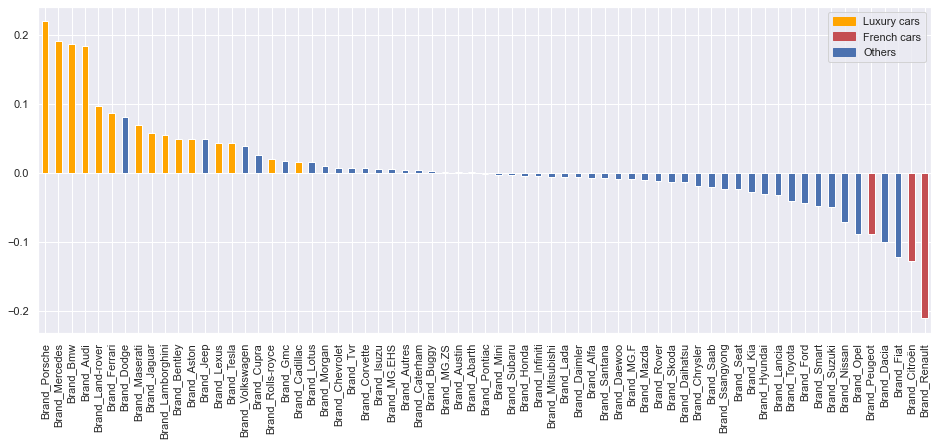

In [27]:
# Getting colors for plot
brands_ = [re.sub(r'Brand_','', brand) for brand in dummy_brands_corr_price.index]

lux_cars = [car for car,value in dict_lux_cars.items() if value == 1]
french_cars = [car for car,value in dict_cars_origin.items() if value == 'france']

colors = []
for brand in brands_:
    if brand in lux_cars:
        colors.append('orange')
    elif brand in french_cars:
        colors.append('r')
    else:
        colors.append('b')
              

# Plotting
plt.figure(figsize = (16,6))
dummy_brands_corr_price.plot.bar(color = colors)

red_patch = mpatches.Patch(color='r', label='French cars')
orange_patch = mpatches.Patch(color='orange', label='Luxury cars')
blue_patch = mpatches.Patch(color='b', label='Others')
plt.legend(handles=[orange_patch, red_patch, blue_patch])

plt.show()

Although there is a clear relationship between different brands and their selling price, a good part of this relationship is kept by just including the "Luxury_Brand" dummy variable and adding the country of origin, specially specifying which are french cars. 

There does not seem that one-hot encoding of Brands is necessary. Moreover, including that many features could slow down future models and lead to overfitting.

#### Testing Frequent Encoder

In [28]:
freq_enc = CountFrequencyEncoder(variables = 'Brand')
freq_enc.fit(X_train)
freq_enc.transform(X_train)['Brand'].corr(y_train['Prices'])

-0.18443543907833207

Encoding brands by their frequency seem to have some correlation with price, therefore it would be reasonable to encode as such this feature. Therefore, we can drop the Brand feature.

In [29]:
X_train = freq_enc.transform(X_train)
X_train.head(3)

,Years,Brand,Kms,Fuel,Emiss_CO2,Cons_litres_100km,Transmission,Doors,Power_CV,Seats,Years_na,Kms_na,Emiss_CO2_na,Cons_litres_100km_na,Doors_na,Power_CV_na,Seats_na,Luxury_brand,Brand_origin
43245,2018.00,356,11.18,Diesel,134.50,6.56,Automatique,4.00,8.00,5.00,0,0,1,1,0,0,0,0,other
51630,2017.00,1013,10.13,Diesel,134.50,6.56,Manuelle,4.00,5.00,5.00,0,0,1,1,0,0,0,0,other
26134,2020.00,3173,8.96,Diesel,134.50,6.56,Semi automatique,4.00,8.00,5.00,0,0,1,1,0,0,0,1,germany


## Regrouping rare labels

In [30]:
rare_encoder = RareLabelEncoder(tol = 0.05, 
                                n_categories = 2, 
                                variables = ['Fuel', 'Transmission'],
                                replace_with = 'Other')

In [31]:
rare_encoder.fit(X_train)

RareLabelEncoder(n_categories=2, replace_with='Other',
                 variables=['Fuel', 'Transmission'])

In [32]:
X_train = rare_encoder.transform(X_train)

In [33]:
# Checking Fuel values
X_train.Fuel.value_counts() / len(X_train)

Diesel    0.51
Essence   0.42
Other     0.07
Name: Fuel, dtype: float64

In [34]:
# Checking Transmission values
X_train.Transmission.value_counts() / len(X_train)

Manuelle      0.55
Automatique   0.40
Other         0.05
Name: Transmission, dtype: float64

## OneHotEncoding 

In [35]:
ohe = OneHotEncoder()
ohe.fit(X_train)
X_train = ohe.transform(X_train)

In [36]:
print(X_train.shape)
X_train.head()

(43717, 25)


,Years,Brand,Kms,Emiss_CO2,Cons_litres_100km,Doors,Power_CV,Seats,Years_na,Kms_na,Emiss_CO2_na,Cons_litres_100km_na,Doors_na,Power_CV_na,Seats_na,Luxury_brand,Fuel_Diesel,Fuel_Essence,Fuel_Other,Transmission_Automatique,Transmission_Manuelle,Transmission_Other,Brand_origin_other,Brand_origin_germany,Brand_origin_france
43245,2018.00,356,11.18,134.50,6.56,4.00,8.00,5.00,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0
51630,2017.00,1013,10.13,134.50,6.56,4.00,5.00,5.00,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0
26134,2020.00,3173,8.96,134.50,6.56,4.00,8.00,5.00,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,1,0
36769,2018.00,3806,11.16,134.50,5.50,4.00,6.00,5.00,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1
17146,2021.00,7182,9.69,149.00,6.56,5.00,5.00,5.00,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1


# Feature Scaling

In [37]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform and wrap the array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

## Correlation with Prices

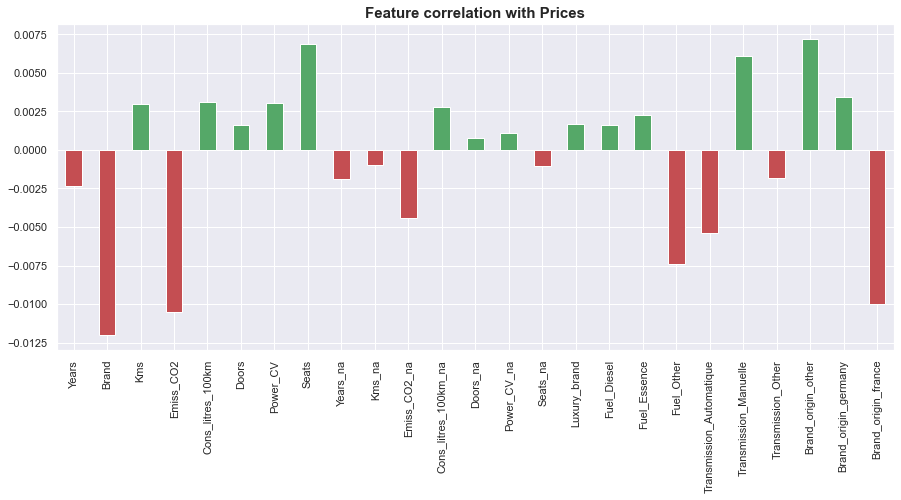

In [38]:
plt.figure(figsize = (15,6))
corr_data = X_train.join(y_train).corr()['Prices'][:-1]
colors = ['g' if corr > 0 else 'r' for corr in corr_data]
corr_data.plot.bar(color = colors)
plt.title('Feature correlation with Prices', weight = 'bold', size = 15)
plt.show()

### Correlation between features

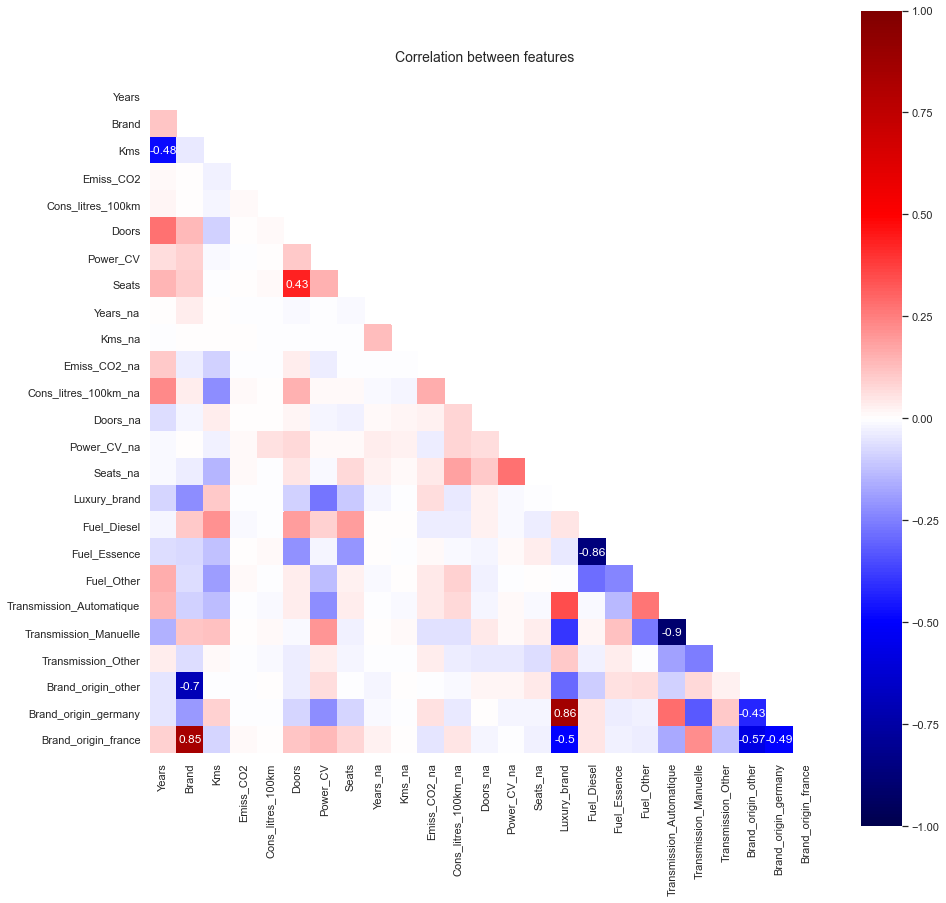

In [39]:
corr = X_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr, mask=mask, annot = True, vmin = -1, vmax=1, square=True, cmap = 'seismic')
    for t in ax.texts:
        
        if abs(float(t.get_text()))>=0.4:
            t.set_text(t.get_text()) 
        else:
            t.set_text("")
plt.title('Correlation between features\n', size = 14)
plt.show()

===================================================================================================
# Saving preprocessed train set

In [40]:
X_train.shape, y_train.shape

((43717, 25), (43717, 1))

In [41]:
X_train.to_csv('xtrain_preprocessed.csv', index=False)
y_train.to_csv('ytrain_preprocessed.csv', index=False)